# Multi-Scenario MORDM

*note: this notebook gives a very detailed examplary way of solving the problems which goes well beyond what is expected of students. Use this model answer as an example of best practice*

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [27]:
from ema_workbench import load_results

experiments, outcomes = load_results('mordm_34.tar.gz')

[MainProcess/INFO] results loaded successfully from /Users/jhkwakkel/Documents/GitHub/epa1361/Week 5-6 - robustness and direct search/mordm_34.tar.gz


there are many ways in which you can make an informed selection. Examples include
* pick best and worst for each outcome of interest
* maximize diversity following Eker & Kwakkel
* visually selected them

Regardless of the used procedure, what matters is that you motivate which scenarios you have selected and why. We start here from the results from the scenario discovery performed in assignment 8

## best case, worst case
First, let's show how we can use best case and worst case as a basis for scenario selection.

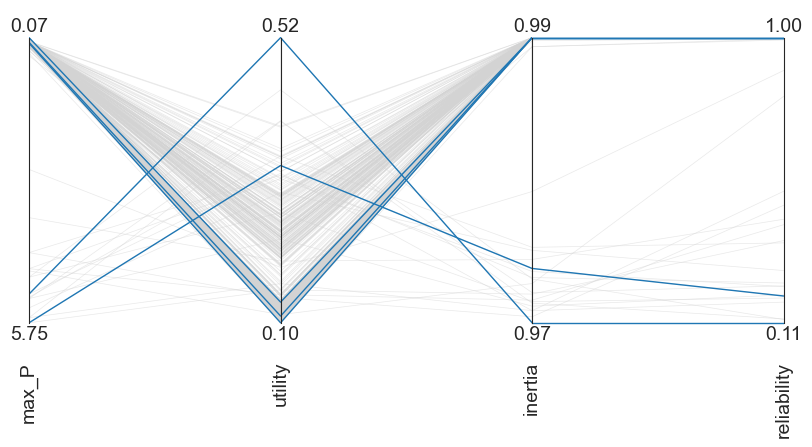

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench.analysis import parcoords

# conditional on y
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# let's get the unique indices for the minima and maxima across 
# all objectives
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transpartant using alpha
# this often helps reveal patterns in the results.
axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1)
axes.invert_axis('max_P')

fig = plt.gcf()
fig.set_size_inches((8, 4))

plt.show()

Above, we see a simple parallel coordinate. In light grey, it shows all the results. In blue, it shows the the results that are at a minimum or maximum on any of the outcomes of interest. Depending on the policy problem, and the general attitude towards risk of the involved stakeholders, as analyst you can choose to focus on either the worst case scenarios, the best case scenarios, or both. 

So how can we identify these cases and turn them into scenarios under which we can apply MORDM?

In [41]:
print(all_data.idxmax())
print(all_data.idxmin())

max_P          314
utility        230
inertia          0
reliability      0
dtype: int64
max_P          152
utility         57
inertia        230
reliability    230
dtype: int64


we now have 8 indices, so we could optimize for each of these 8 scenarios. This might be a bit overkil, so you could also take a worst case stance. In that case,  you would use the max for max_P and the minimum for the others. Below, I just typed the indices from the above overview. 

In [42]:
# also all we need are the uncertainty columns
selected = experiments.loc[[314, 57, 230], ['b', 'delta', 'mean', 'q', 'stdev']]
selected

,b,delta,mean,q,stdev
314,0.198420,0.937121,0.042991,3.556542,0.001917
57,0.228793,0.930251,0.029675,3.642005,0.001046
230,0.216924,0.946909,0.035904,2.648620,0.001199


Now that we have a DataFrame with the uncertainties, we can easily convert these into Scenario instances.

In [43]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]
    

This completes how to create scenarios under which to optimize using best case/worst case reasoning. We also show now how a more involved techinique based on maximum diversity can be done.

## Eker & Kwakkel
This code is adapted from the source found in the [GitHub repository](https://github.com/sibeleker/MORDM---Multi-scenario-search). The main change is a switch to use a DataFrame for the outcomes, rather than the dictionary as returned by the workbench.  We start with normalizing all outcomes on unit interval. We can use scikit learn for this as shown below.


In [6]:
from sklearn import preprocessing

experiments_of_interest = experiments.loc[y]
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes.items()})

# normalize outcomes on unit interval to ensure equal weighting of outcomes
x = outcomes_df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_outcomes = pd.DataFrame(x_scaled, columns=outcomes_df.columns)


Next, we have to make a choice. How many scenarios do we want to consider. Below, I assume that we want to use 4 scenarios. So, we create all possible permutations of 4 scenarios selected from the set of all scenarios.

In [7]:
import itertools

n_scen = experiments.loc[y].shape[0]
indices = range(n_scen)
set_size = 4
n_scen
combinations = itertools.combinations(indices, set_size)
combinations = list(combinations)

In [8]:
print(len(combinations))

473490550


Tthe numbere of possible subsets is very large, close to 500 million. We now need to calculate the diversity of each of these almost 500 million combinations. Rather than solve this in one for loop, let's split this up over the multiple cores of our machines. Following modern Python best practices, we use a `ProcessPoolExecutor` from `concurrent.futures` for this. However, even on my 10 core machine, this takes multiple hours, so let's randomly select 100.000 combinations and pick the most diverse one out of this. For a real case, I would let it run overnight, but for an example this is not necessary.

In [9]:
import random

sampled_combinations = random.sample(combinations, 100000)

So now we can calculate the diversity of each of these 100.000 combinations. For this, we first need to calculate the distance between all pairs of scenarios. Scipy has some convenience functions for this as shown below. Next, we have to calculate the diversity of each set of 4 scenarios. We do this using the ProcessPoolExecutor and split the 100.000 possible pairs over the cores available on the machine. We then combine the results from these 10 parallel calculations.

Because we want to run the calculations in parallel, the `find_maxdiverse_scenarios` function has to be defined in a python .py file that we import.

In [10]:
from concurrent.futures import ProcessPoolExecutor
import os
import functools
from scipy.spatial.distance import pdist, squareform

# the relevant code is in a .py file to esnure parallization works within the notebook
from assignment_9_scenario_selection import find_maxdiverse_scenarios

# calculate the pairwise distances between the normalized outcomes
distances = squareform(pdist(normalized_outcomes.values))

cores = os.cpu_count()
partial_function = functools.partial(find_maxdiverse_scenarios, distances)

# setup the pool of workers and split the calculations over the set of cores
with ProcessPoolExecutor(max_workers=cores) as executor:
    worker_data = np.array_split(sampled_combinations, cores)
    results = [e for e in executor.map(partial_function, worker_data)]
    results = list(itertools.chain.from_iterable(results))


Just to show that we have results, let's check the most diverse result

In [11]:
results.sort(key=lambda entry:entry[0], reverse=True)
most_diverse = results[0]
most_diverse

([1.114390269707737], array([ 12,  33,  97, 209]))

Here the first number in the tuple gives the diversity score. The second element is an array with the indices for the 4 scenarios that together produce this highest diversity score. We can now use these indices to create the Scenarios under which we want to optimize.

In [12]:
from ema_workbench import Scenario

selected = experiments.loc[most_diverse[1], ['b', 'delta', 'mean', 'q', 'stdev']]
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

for scenario in scenarios:
    print(scenario)

Scenario({'b': 0.2090083388474371, 'delta': 0.9411170412576872, 'mean': 0.04222386597575, 'q': 3.5865158641845065, 'stdev': 0.0019485361404024})
Scenario({'b': 0.3545534174935311, 'delta': 0.9410013244484868, 'mean': 0.0233295475957621, 'q': 3.476510459575324, 'stdev': 0.0020950329650296})
Scenario({'b': 0.2330848424105897, 'delta': 0.940855247582668, 'mean': 0.0419389238575562, 'q': 2.738137264303975, 'stdev': 0.0020063354916377})
Scenario({'b': 0.2320336285210324, 'delta': 0.9522493752703804, 'mean': 0.0302666401537138, 'q': 3.870555186068722, 'stdev': 0.0014661586793575})


This completes how to select based on maximum diversity. Regardless of the chosen approach, the next step is perform optimiation for each scenario.

## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


In [13]:
from ema_workbench import (Model, RealParameter, ScalarOutcome)

from dps_lake_model import lake_model

model = Model('lakeproblem', function=lake_model)

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2),
                RealParameter("r2", 0, 2),
                RealParameter("w1", 0, 1)]

#specify outcomes
# note how we need to explicitely indicate the direction
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

Since we have to do the same thing for each scenario, it is convenient to wrap this in a function we can call with the scenario under which we want to optimize. Since it is best practice to run the optimization for several seeds and store the archives for calculating convergence metrics, we do this as well. Last, we merge the results across the seeds using an epsilon dominated sort. This ensures that the final pareto set for each scenario is the merged set across the seeds.

In [14]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated)

ema_logging.log_to_stderr(ema_logging.INFO)

def optimize(scenario, nfe, model, epsilons):
    results = []
    convergences = []
    problem = to_problem(model, searchover="levers")

    with MultiprocessingEvaluator(model) as evaluator:
        for i in range(5):
            convergence_metrics = [
                ArchiveLogger(
                    "./archives",
                    [l.name for l in model.levers],
                    [o.name for o in model.outcomes],
                    base_filename=f"assignemnt_9_{scenario.name}_seed_{i}.tar.gz",
                ),
                EpsilonProgress(),
            ]

            result, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                         convergence=convergence_metrics,
                                         epsilons=epsilons,
                                         reference=scenario)

            results.append(result)
            convergences.append(convergence)
    
    # merge the results using a non-dominated sort  
    reference_set = epsilon_nondominated(results, epsilons, problem)    
            
    return reference_set, convergences


results = []
for scenario in scenarios:
    epsilons = [0.05,]*len(model.outcomes)
    
    # note that 100000 nfe is again rather low to ensure proper convergence
    results.append(optimize(scenario, 1e5, model, epsilons))


[MainProcess/INFO] pool started with 10 workers
100015it [07:21, 226.39it/s]                                                   
[MainProcess/INFO] optimization completed, found 10 solutions
100032it [06:58, 238.80it/s]                                                   
[MainProcess/INFO] optimization completed, found 9 solutions
100%|█████████████████████████████████| 100000/100000 [06:58<00:00, 238.87it/s]
[MainProcess/INFO] optimization completed, found 11 solutions
100032it [06:50, 243.78it/s]                                                   
[MainProcess/INFO] optimization completed, found 9 solutions
100015it [06:57, 239.62it/s]                                                   
[MainProcess/INFO] optimization completed, found 9 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 10 workers
100001it [07:21, 226.68it/s]                                                   
[MainProcess/INFO] optimization completed, found 8 solutions
100008it [07:09, 232

Now that we have our results for five seeds for each scenario, we can calculate our convergence metrics. This again has to be done on a scenario and seed basis. A simple helper function is quite useful for this. I am using the hypervolume metric as provided by platypus, rather than the one that comes with the workbench. The reason for this is that I can provide my own minima an maxima instead of having to rely on a reference set. This also allows me to easily calculate hypervolume for all scenarios in the same reference space. 

I am storing the results into a long list of dataframes. To these dataframes, I add the seed number and scenario name as additional columns. This will make plotting a lot easier as you will see

In [15]:
from platypus import Hypervolume
from ema_workbench.em_framework.optimization import rebuild_platypus_population


def calculate_convergence_metrics(problem, archives_file):
    hv = Hypervolume(minimum=[0, 0, 0, 0], maximum=[12, 3, 1, 1])
    archives = ArchiveLogger.load_archives(archives_file)
    metrics = []
    for nfe, archive in archives.items():
        population = rebuild_platypus_population(archive, problem)
        metrics.append(dict(hypervolume=hv.calculate(population), nfe=nfe))
        
    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True, ignore_index=True)    
    return metrics


problem = to_problem(model, searchover="levers")
convergence_calculations = []
for (refset, eps_progress), scenario in zip(results, scenarios):
    for seed, seed_eps in zip(range(5), eps_progress):
        archive_file = f"./archives/assignemnt_9_{scenario.name}_seed_{seed}.tar.gz"
        metrics = calculate_convergence_metrics(problem, archive_file)
        metrics["seed"] = seed
        metrics["scenario"] = scenario.name
        metrics["epsilon_progress"] = seed_eps.epsilon_progress   
        
        convergence_calculations.append(metrics)
convergence = pd.concat(convergence_calculations, ignore_index=True)

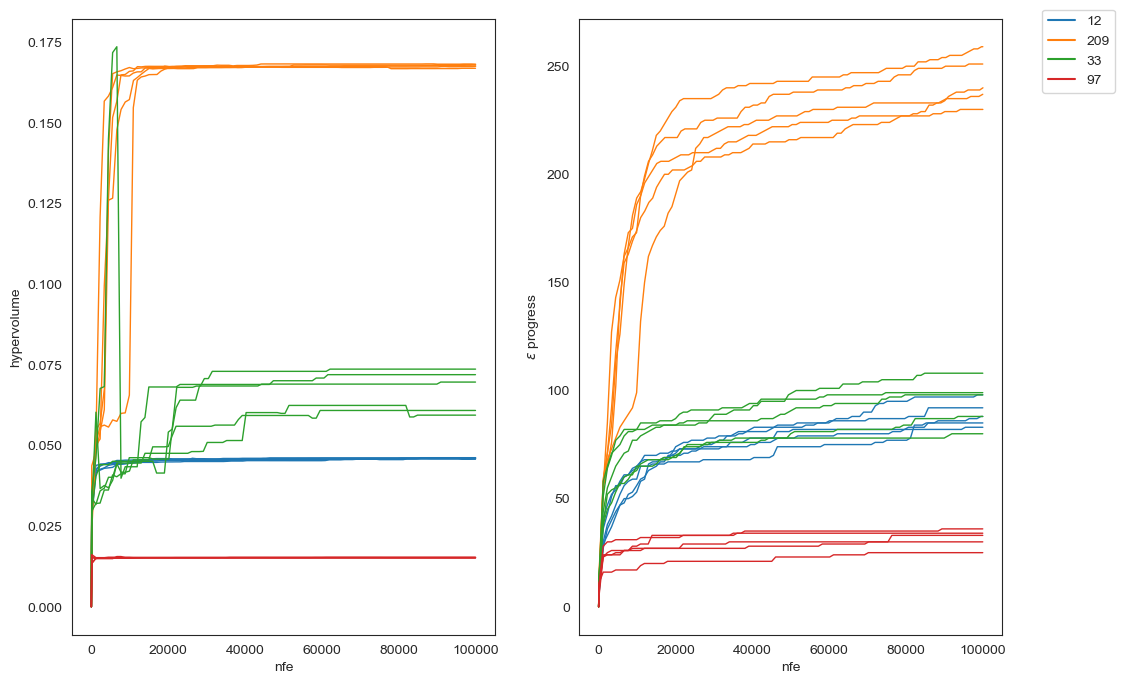

In [16]:
import matplotlib as mpl
import seaborn as sns


fig, (ax1, ax2) = plt.subplots(ncols=2)

colors = sns.color_palette()

legend_items = []
for (scenario_name, scores), color in zip(convergence.groupby("scenario"), colors):
    # we use this for a custom legend
    legend_items.append((mpl.lines.Line2D([0, 0], [1, 1], c=color), scenario_name))
    for seed, score in scores.groupby("seed"):
        ax1.plot(score.nfe, score.hypervolume, c=color, lw=1)
        ax2.plot(score.nfe, score.epsilon_progress, c=color, lw=1)


ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')

# create our custom legend
artists, labels = zip(*legend_items)
fig.legend(artists, labels, bbox_to_anchor=(1,0.9))

plt.show()

Above, we show the convergence in terms of hypervolume and $\epsilon$-progress. To show the search for each scenario, we have used a seperate color for each scenario. We can see that scenarios 209, 12, and 97 converge to essentially the same hypervolume across seeds. In contrast scenario 33 shows still some variation in hypervolume across seeds. This suggests that this scenario might not yet have converged. 

The fact that the hypervolume across the scenarios is different is also telling. Remeber, hypervolume is a measure of the volume a given Pareto set covers of the objective space. Since we used the same reference space for all calculations, we can compare hypervolume. The fact that scenario 209 has a much higher hypervolume then scenario 29 suggest that sceanrio 209 reflects beneficial conditions while scenario 29 reflects pessimistic conditions.

below is a quick visualization of the trade-offs found for each scenario. It does reveal how optimizing under differen scenarios reveals different trade-offs

Note that, in a way, this is a misleading figure because the scenario under which each of these sets of solutions is being evaluated is not the same. So we cannot use this figure to select our prefered solution. For this, we will have to re-evaluate all solutions over a wider sampling of scenarios.

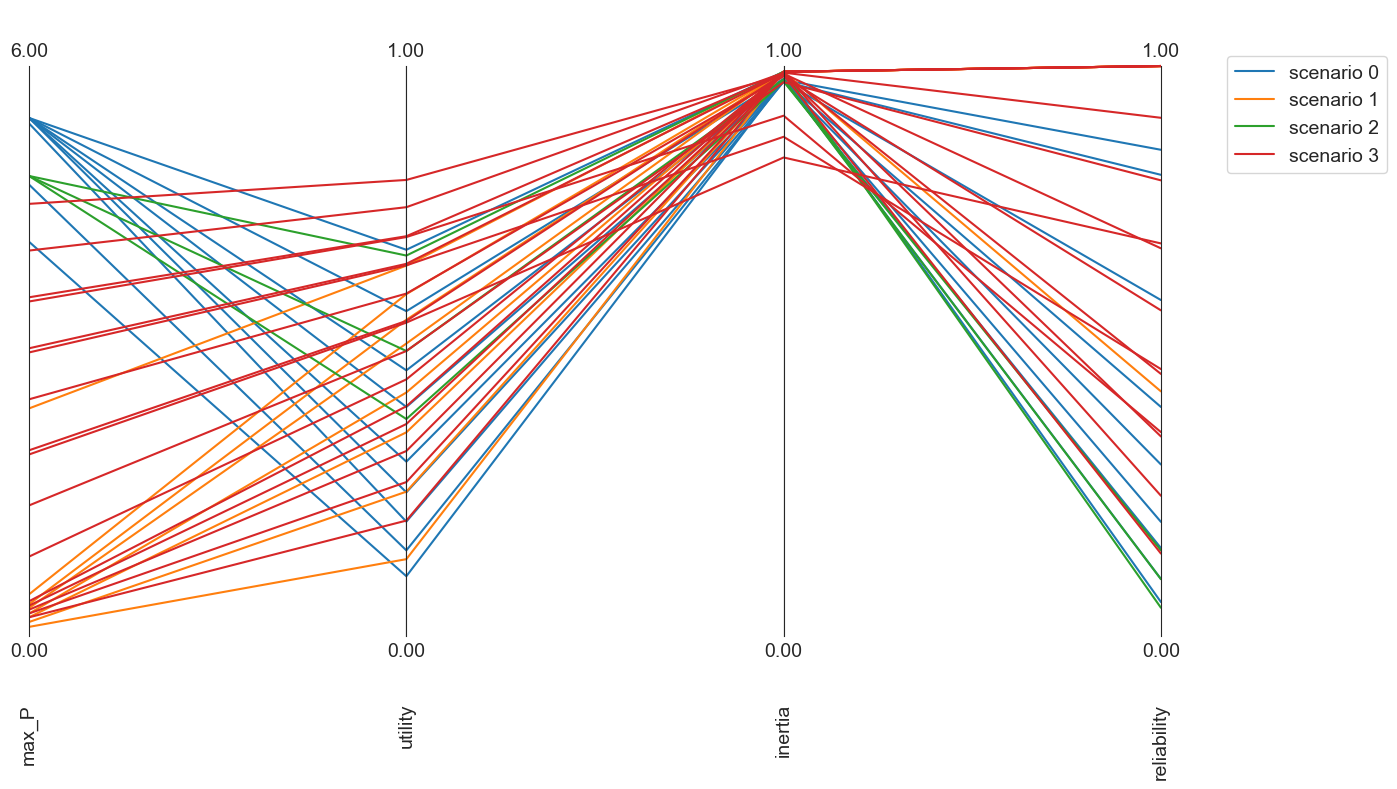

In [17]:
from ema_workbench.analysis import parcoords

colors = iter(sns.color_palette())

data = results[0][0].iloc[:, 5::]
limits = parcoords.get_limits(data)

limits.loc[0, ['inertia', 'reliability']] = 1
limits.loc[0, 'max_P'] = 6 # max over results based on quick inspection not shown here
limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.iloc[:, 5::]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()


## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [18]:
from ema_workbench import Policy

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:5]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)

In [19]:
with MultiprocessingEvaluator(model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 36 policies * 1 model(s) = 36000 experiments
IOStream.flush timed out
100%|███████████████████████████████████| 36000/36000 [02:01<00:00, 296.70it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


In [20]:
experiments, outcomes = reeevaluation_results

thresholds = {'utility':0.75, 'inertia':0.99, 'reliability':0.8}

overall_scores = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    scores = {}
    for k, v in outcomes.items():
        try:
            n = np.sum(v[logical]>=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

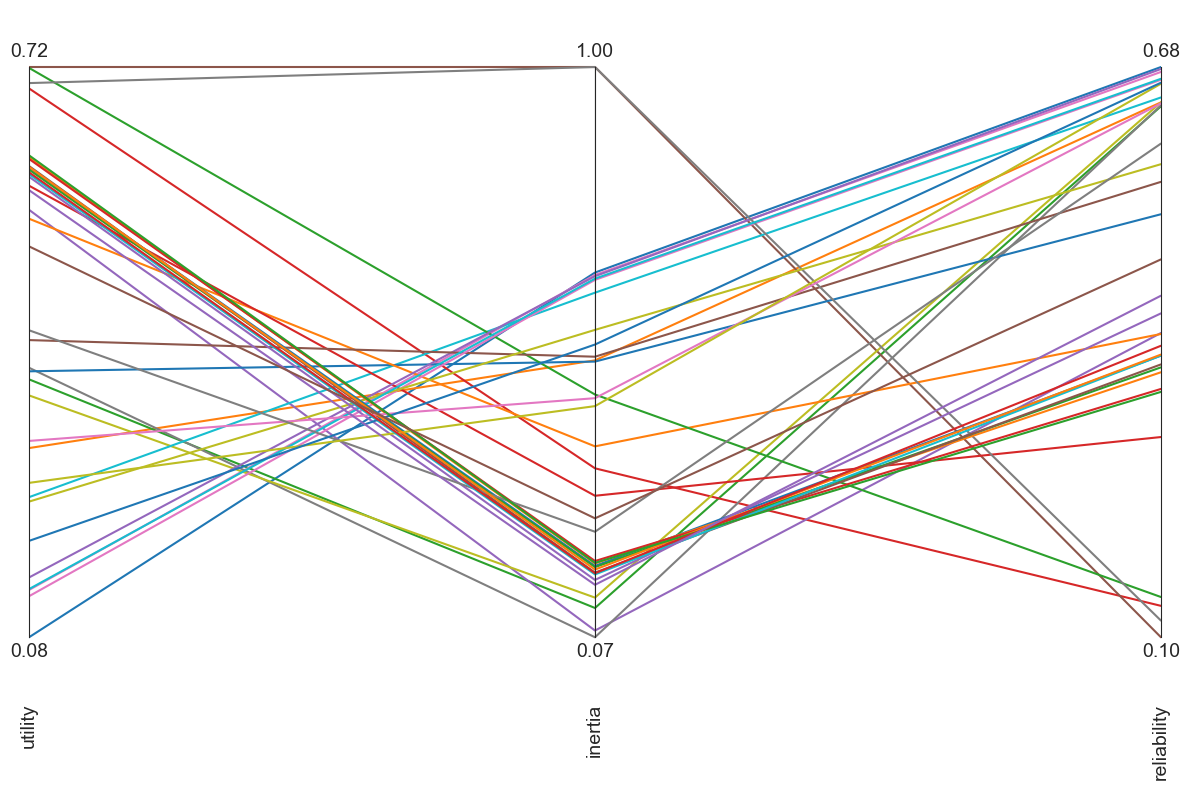

In [21]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

Above we see the robustness according to the domain criterion. We see a clear tradeoff between inertia and reliability as indiced by the crossing lines. There is also a bit of tradeoff between utility and inertia, but there are some solutions that are able to achive both high utility and low inertia, but at the expense of low reliability. Coversely, some of the best solutions in terms of reliability have very low utility robustness. 

There are many ways of coding the regret calculating. Here I choose to use dataframes. I basically wanted to use the groupby method on a dataframe with the regret for each policy in each scenario. Reasoning backward from there, I arrived at the code shown below. A notable complication in the code is that we have a mix of objectives to be maximized and objectives to be minimized. Regret calculations have to be adapted accordingly.


In [122]:
experiments, outcomes = reeevaluation_results

# setup a dataframe for the outcomes
# we add scenario and policy as additional columns
# we need scenario because regret is calculated on a scenario by scenario basis
# we add policy because we need to get the maximum regret for each policy.
outcomes = pd.DataFrame(outcomes)
outcomes['scenario'] = experiments.scenario
outcomes['policy'] = experiments.policy

def calculate_regret(x):
    # policy is non numeric, so max is not defined for this
    best = x.max(numeric_only=True)
    
    # max_P is minimized so best performance is minimum.
    best['max_P'] = x.max_P.min()    
    
    # again we need to handle max_P a bit different
    regret = best -x.loc[:, best.index]
    regret['max_P'] = x.max_P - best.max_P

    # we add policy back into our regret dataframe
    # so we know the regret for each policy
    regret['policy'] = x.policy
    return regret

# we want to calculate regret on a scenario by scenario basis
regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)

# as last step, we calculate the maximum regret for each policy
max_regret = regret.groupby('policy').max()

Now that we have our regret, we can visualize this again using a parallel coordinate plot. I have reorder the columns, because it highlights some of the trade-offs more clearly.

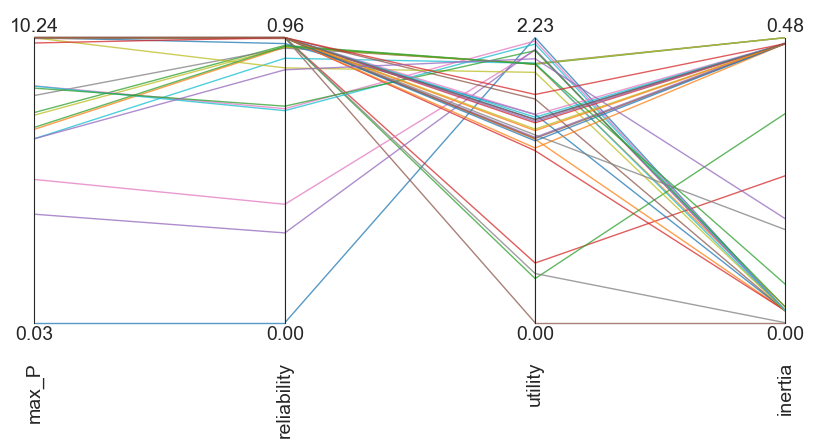

In [140]:
# I reorder the columns
max_regret = max_regret[['max_P', 'reliability','utility', 'inertia']]

limits = parcoords.get_limits(max_regret)
paraxes = parcoords.ParallelAxes(max_regret)
paraxes.plot(max_regret, lw=1, alpha=0.75)

# let's resize the figure a bit
fig = plt.gcf()
fig.set_size_inches(8, 4)

plt.show()

So what do we see? Low regret for maximum Pollution and reliability go hand in hand. There is also evidently a trade off between these two objectives and utility. So high regret for utility coincides with low regret for maximum pollution and reliability and vice versa. 

# Closing remarks
This notebook is a very detailed model answer to this assignment reflecting the state of the art and best practices for using Many Objective Optimization for supporting decision making under deep uncertainty. The key lesson is that Pareto optimal solutions identified in MORDM are scenario dependend. By repeating the MOEA-based search for several carefully selected scenarios we can easily alleviate this scenario dependency problem and produce a rich and diverse set of candidate solutions we can subsequently analyze over a much wider sampling of the deep uncertainties to identify promosing robust candidate solutions. 

